# December 2020

In [1]:
import os
import sys
import h5py
import pickle
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.plot_functions import mk_pie_plot, mk_data_summary_plot

In [2]:
base_dir = pjoin(os.environ['HOME'], 'Documents/A1')
data_dir = pjoin(base_dir, 'Data')
results_dir = pjoin(base_dir, 'results')

In [3]:
nb_std = 1
processed_dir = pjoin(base_dir, 'python_processed')
h_load_file = pjoin(processed_dir, "organized_nb_std={:d}.h5".format(nb_std))

In [4]:
load_df_file = pjoin(processed_dir, 'processed_nb_std={:d}'.format(nb_std), "all.df")
df_all = pd.read_pickle(load_df_file)

## Dec/18

### Visualizing trial averages

Here we plot average responses for a given trial type using all cells from all experiments. Passive trials also included.  Different behavior labels are define according to these frequencies:

- target: $7, 10$ kHz
        - For target frequencies, animals should start licking after $1s$ of stimulus presentation ($t = 45$), because there will be a reward present.
        - **hit**: if they lick
        - **miss**: if they don't lick

- nontarget: $14, 20$ kHz
        - For nontarget frequencies, animals should not lickat all because they are trained to detect, and ignore these higher frequency stimuli. No reward will be presented during this trials.
        - **correcreject**: if they don't lick
        - **falsealarm**: if they start licking (they'll find no reward and just stop after few licks).

Interestingly, at $f = 14$ kHz avg traces for passive and falsealarm trials overlap almost perfectly.  Another interesting point is that during target frequencies, passive trials have larger amplitude compared to behavior trials.  Is this because these are not passive trials, and animals are actively listening with lots of focus, but they don't lick because they know there are no rewards?

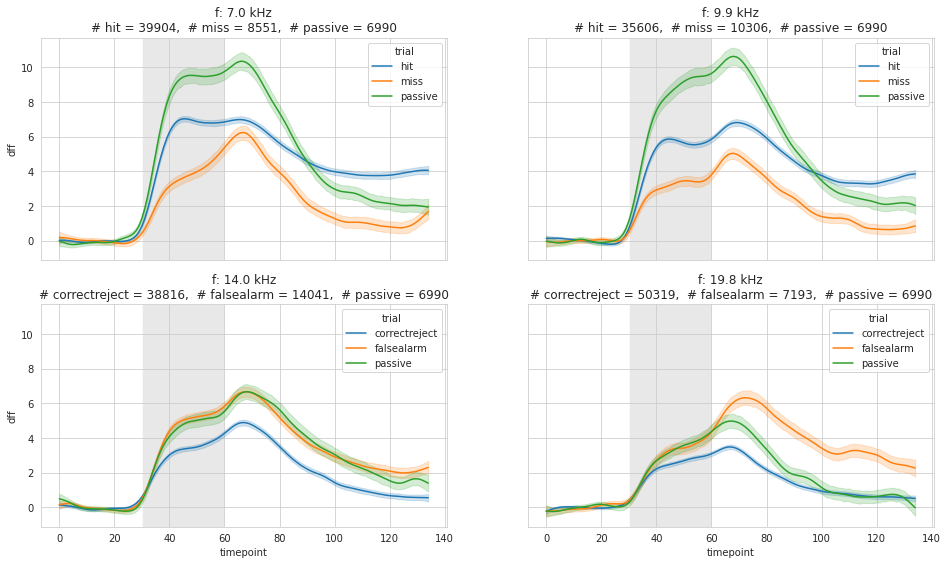

In [26]:
behavior_freqs = sorted(df_all.loc[df_all.trial != 'passive'].stimfreq.unique())

sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 9), sharex='all', sharey='all')
for idx, freq in enumerate(behavior_freqs):
    i, j = idx // 2, idx % 2
    
    if freq == 7000:
        freq_list = [freq, 7071]
        trials_list = ['hit', 'miss']
    elif freq == 9899:
        freq_list = [freq, 10000]
        trials_list = ['hit', 'miss']
    elif freq == 14000:
        freq_list = [freq, 14142]
        trials_list = ['correctreject', 'falsealarm']
    elif freq == 19799:
        freq_list = [freq, 20000]
        trials_list = ['correctreject', 'falsealarm']
    trials_list.extend(['passive'])
    
    selected_df = df_all.loc[(df_all.stimfreq.isin(freq_list)) & (df_all.trial.isin(trials_list))]
    sns.lineplot(data=selected_df, x='timepoint', y='dff',
                 hue='trial', hue_order=trials_list, ax=ax_arr[i, j])
    ax_arr[i, j].axvspan(30, 60, facecolor='lightgrey', alpha=0.5, zorder=0)
    
    # get title
    trial_counts = Counter(selected_df[selected_df.timepoint == 0].trial)
    msg = "f: {:.1f} kHz\n"
    values = [freq / 1000]
    for label_idx, item in enumerate(trials_list):
        if label_idx == 0:
            msg += "# {:s} = {:d}"
        else:
            msg += ",  # {:s} = {:d}"
        values.extend([item, trial_counts[item]])
    ax_arr[i, j].set_title(msg.format(*values))

fig.tight_layout()
plt.show()

#### 95% confidence interval vs. standard deviation

All figures so far are showing mean and the shaded area is 95% CI.  I looked at the source code of the plotting package I'm using to make sure this is the case.  They bootstrap the data *then* computes the confidence interval on it.  This leads to a slightly better result, but at the end of the day it is showing 95% confidecne interval.

Now I will remake above plots, but this time contrasting 95% CI with just standard deviation.

In [132]:
output_trial, output_freq = bag_of_trajectories(h_load_file)

100%|██████████| 34/34 [00:01<00:00, 25.40it/s]


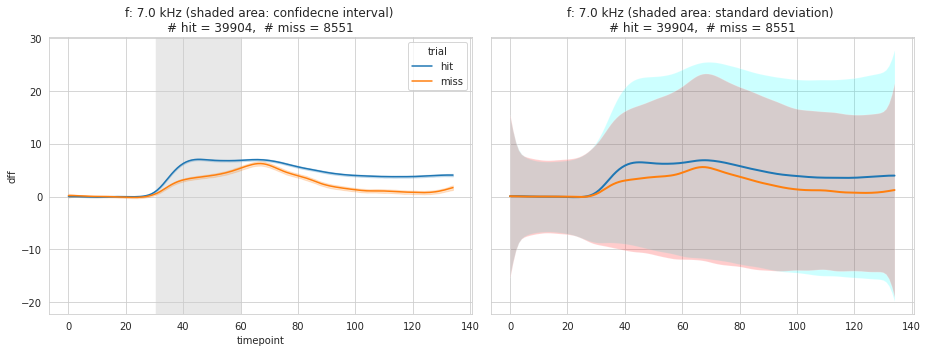

In [134]:
behavior_freqs = sorted(df_all.loc[df_all.trial != 'passive'].stimfreq.unique())

sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(1, 2, figsize=(13, 5), sharex='all', sharey='all')

freq = 7000
freq_list = [freq, 7071]
trials_list = ['hit', 'miss']
selected_df = df_all.loc[(df_all.stimfreq.isin(freq_list)) & (df_all.trial.isin(trials_list))]
sns.lineplot(data=selected_df, x='timepoint', y='dff',
             hue='trial', hue_order=trials_list, ax=ax_arr[0])
ax_arr[0].axvspan(30, 60, facecolor='lightgrey', alpha=0.5, zorder=0)

for trial in trials_list:
    color = 'cyan' if trial == 'hit' else 'red'
    idxs = np.where(output_trial['df'].trial == trial)[0]
    mean = output_trial['dff'][idxs].mean(0)
    std = output_trial['dff'][idxs].std(0)
    ax_arr[1].plot(mean, lw=2)
    ax_arr[1].fill_between(range(nt), mean-std, mean+std, facecolor=color, alpha=0.2)


# get title
trial_counts = Counter(selected_df[selected_df.timepoint == 0].trial)
msg1 = "f: {:.1f} kHz (shaded area: confidecne interval) \n"
msg2 = "f: {:.1f} kHz (shaded area: standard deviation) \n"
values = [freq / 1000]
for label_idx, item in enumerate(trials_list):
    if label_idx == 0:
        msg1 += "# {:s} = {:d}"
        msg2 += "# {:s} = {:d}"
    else:
        msg1 += ",  # {:s} = {:d}"
        msg2 += ",  # {:s} = {:d}"
    values.extend([item, trial_counts[item]])
ax_arr[0].set_title(msg1.format(*values))
ax_arr[1].set_title(msg2.format(*values))

fig.tight_layout()
plt.show()

### Classification on a bag of trajectories

Let us take all the trajectories recorded from neurons.  A given trajectory is either:

1) *EXC*: maximum absolute intensity of the reponses is positive (the cell was excited)<br>
2) *SUP*: maximum absolute intensity of the reponses is negative (the cell was inhibited)

These trajectories come from different trial types.  Here we focus only on **hit** and **miss** trials. We would like to learn a classifier that maps each trajectory to the trial label that it originates from.  We can take the entire trajectory and feed it into classifier, but first we define a simple scalar measure and use that.

#### Response magnitude:
Defined as the mean of trajectory values during times $t \in [40, 45)$.  This is the last third of listening period $t \in [30, 45)$, right before licking time onset $t = 45$. We take each trajectory, compute response magnitude, and try to predict trial type label from this scalar.

In [137]:
trange = range(40, 45)

x = output_trial['dff']
df = output_trial['df']
labels = df.trial.to_numpy()

hit_or_miss = np.where(df.trial.isin(['hit', 'miss']))[0]

x = x[hit_or_miss]
labels = labels[hit_or_miss]

tags = []
max_act = []
for i in range(len(x)):
    _val = max(x[i][trange], key=abs)
    _tag = 'SUP' if _val < 0 else 'EXC'
    max_act.append(_val)
    tags.append(_tag)

mag = x[:, trange].mean(-1, keepdims=True)
y = np.array([output_trial['str2int'][item] for item in labels])

x.shape, labels.shape, mag.shape, y.shape

((94367, 135), (94367,), (94367, 1), (94367,))

In [138]:
tst_indxs = []
trn_indxs = []

for trial in ['hit', 'miss']:
    indxs = np.where(labels == trial)[0]
    tst_indxs.append(indxs[:len(indxs)//5])
    trn_indxs.append(indxs[len(indxs)//5:])

tst_indxs = np.concatenate(tst_indxs)
trn_indxs = np.concatenate(trn_indxs)

assert not set(tst_indxs).intersection(set(trn_indxs))

In [139]:
from sklearn.linear_model import LogisticRegression

trange = range(40, 45)
clf = LogisticRegression(
    # penalty='l2',
    # C=0.1,
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
).fit(mag[trn_indxs], y[trn_indxs])


from sklearn.metrics import balanced_accuracy_score

y_pred = clf.predict(mag[tst_indxs])
balanced_accuracy_score(y[tst_indxs], y_pred)

0.548780148609187

Classifier performance: 54 %, barely above chance

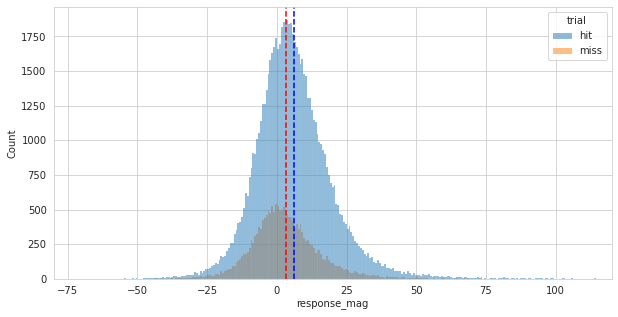

In [147]:
data_dict = {'response_mag': mag.flatten(), 'trial': labels}
tmp_df = pd.DataFrame.from_dict(data_dict)

plt.figure(figsize=(10, 5))
sns.histplot(data=tmp_df, x='response_mag', hue='trial')
plt.axvline(mag[labels == 'hit'].mean(0), color='b', ls='--')
plt.axvline(mag[labels == 'miss'].mean(0), color='r', ls='--')
plt.xlim(-80, 120)
plt.show()

#### What if we just used EXC cells only?

In [152]:
sup_indxs = np.where(np.array(tags) == 'SUP')[0]
x_exc = np.delete(x, sup_indxs, axis=0)
labels_exc = np.delete(labels, sup_indxs, axis=0)
mag_exc = np.delete(mag, sup_indxs, axis=0)
y_exc = np.array([output_trial['str2int'][item] for item in labels_exc])

In [153]:
tst_indxs = []
trn_indxs = []

for trial in ['hit', 'miss']:
    indxs = np.where(labels_exc == trial)[0]
    tst_indxs.append(indxs[:len(indxs)//5])
    trn_indxs.append(indxs[len(indxs)//5:])

tst_indxs = np.concatenate(tst_indxs)
trn_indxs = np.concatenate(trn_indxs)

assert not set(tst_indxs).intersection(set(trn_indxs))

In [155]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
).fit(mag[trn_indxs], y[trn_indxs])


from sklearn.metrics import balanced_accuracy_score

y_pred = clf.predict(mag_exc[tst_indxs])
balanced_accuracy_score(y_exc[tst_indxs], y_pred)

0.5246829697902216

Classifier performance: 52 %, again chance level

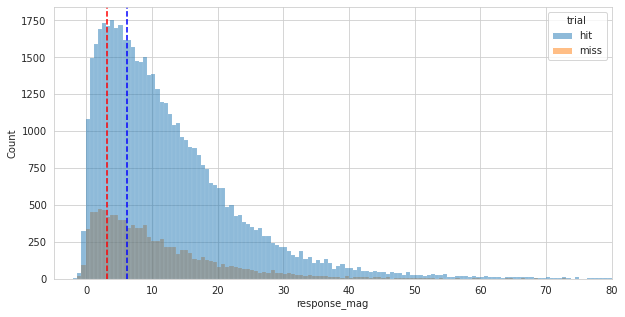

In [159]:
data_dict = {'response_mag': mag_exc.flatten(), 'trial': labels_exc}
tmp_df = pd.DataFrame.from_dict(data_dict)

plt.figure(figsize=(10, 5))
sns.histplot(data=tmp_df, x='response_mag', hue='trial')
plt.axvline(mag[labels == 'hit'].mean(0), color='b', ls='--')
plt.axvline(mag[labels == 'miss'].mean(0), color='r', ls='--')
plt.xlim(-5, 80)
plt.show()